In [1]:
from hest import iter_hest
import scanpy as sc
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
id_list = ["ZEN49"]

adata = None
adata_stage_30 = None
adata_sample_30 = None
adata_stage_50 = None
adata_sample_50 = None
adata_stage_70 = None
adata_sample_70 = None

int_id = 0
for st in iter_hest('ocamargo/hest_data', id_list=id_list):
    adata = st.adata
    adata.var_names_make_unique()
    adata.obsm["coord"] = adata.obs[["array_col", "array_row"]].to_numpy()

    # Flip Y-axis
    adata.obsm['coord'][:, 1] = adata.obsm['coord'][:, 1] * (-1)

    # Preprocess adata
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=500)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Load pre-normalized stage data
    adata_stage_30 = sc.read_h5ad(f'./HEST_TASK8/{id_list[int_id]}/down_ratio0.3/recovered_data.h5ad')
    adata_sample_30 = sc.read_h5ad(f'./HEST_TASK8/{id_list[int_id]}/down_ratio0.3/sampled_data.h5ad')
    adata_stage_50 = sc.read_h5ad(f'./HEST_TASK8/{id_list[int_id]}/down_ratio0.5/recovered_data.h5ad')
    adata_sample_50 = sc.read_h5ad(f'./HEST_TASK8/{id_list[int_id]}/down_ratio0.5/sampled_data.h5ad')
    adata_stage_70 = sc.read_h5ad(f'./HEST_TASK8/{id_list[int_id]}/down_ratio0.7/recovered_data.h5ad')
    adata_sample_70 = sc.read_h5ad(f'./HEST_TASK8/{id_list[int_id]}/down_ratio0.7/sampled_data.h5ad')

/blue/tkahveci/ocamargo/.conda/envs/hest/lib/python3.10/site-packages/hestcore/wsi.py:27: UserWarning: CuImage is not available. Ensure you have a GPU and cucim installed to use GPU acceleration.
  warnings.warn("CuImage is not available. Ensure you have a GPU and cucim installed to use GPU acceleration.")


In [3]:
adata_sample_30.obsm['coord'][:, 1] = adata_sample_30.obsm['coord'][:, 1] * (-1)

In [4]:
adata_stage_30.obsm['coord'][:, 1] = adata_stage_30.obsm['coord'][:, 1] * (-1)

In [5]:
adata_sample_50.obsm['coord'][:, 1] = adata_sample_50.obsm['coord'][:, 1] * (-1)

In [6]:
adata_stage_50.obsm['coord'][:, 1] = adata_stage_50.obsm['coord'][:, 1] * (-1)

In [7]:
adata_stage_70.obsm['coord'][:, 1] = adata_stage_70.obsm['coord'][:, 1] * (-1)

In [8]:
adata_sample_70.obsm['coord'][:, 1] = adata_sample_70.obsm['coord'][:, 1] * (-1)

In [9]:
# 1. Get common genes
used_gene_30 = adata_stage_30.var.index
used_gene_50 = adata_stage_50.var.index
used_gene_70 = adata_stage_70.var.index
common_genes = used_gene_30.intersection(used_gene_50).intersection(used_gene_70).intersection(adata.var.index)

# 2. Compute correlations safely
def compute_correlations(adata_down, adata_full, genes):
    pr = np.zeros(len(genes))
    for i, gene in enumerate(tqdm(genes)):
        x = adata_down[:, gene].X.toarray().squeeze()
        y = adata_full[:, gene].X.toarray().squeeze()
        try:
            pr[i] = pearsonr(x, y)[0]
        except:
            pr[i] = np.nan  # catch constant input error
    return pr

pr_30 = compute_correlations(adata_stage_30, adata, common_genes)
pr_50 = compute_correlations(adata_stage_50, adata, common_genes)
pr_70 = compute_correlations(adata_stage_70, adata, common_genes)

  1%|          | 3/500 [00:00<00:17, 27.75it/s]/scratch/local/291432/ipykernel_35254/1351162917.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pr[i] = pearsonr(x, y)[0]
100%|██████████| 500/500 [00:07<00:00, 64.30it/s]


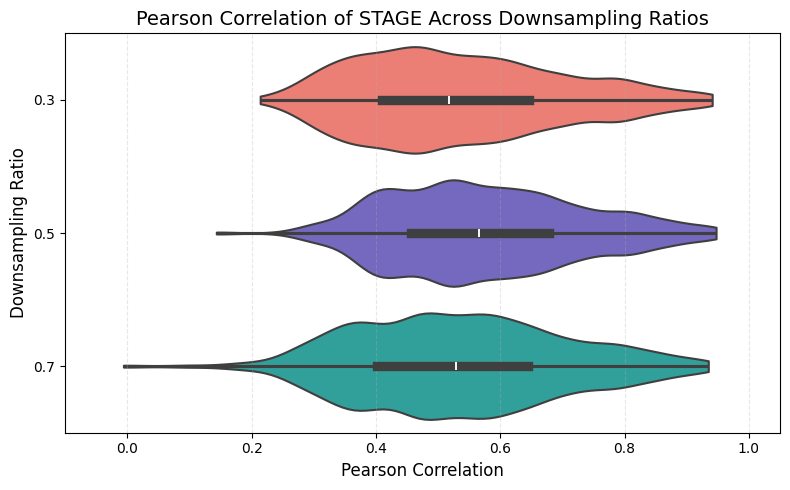

In [10]:
# Example DataFrame
df = pd.DataFrame({
    'Correlation': np.concatenate([pr_30, pr_50, pr_70]),
    'Downsampling Ratio': (['0.3'] * len(pr_30)) + (['0.5'] * len(pr_50)) + (['0.7'] * len(pr_70))
})
df = df.dropna()

# Plot
plt.figure(figsize=(8, 5))

ax = sns.violinplot(
    data=df,
    x='Correlation',
    y='Downsampling Ratio',
    density_norm='area',
    inner='box',
    hue='Downsampling Ratio',
    palette=['#FF6F61', '#6A5ACD', '#20B2AA'],
    linewidth=1.5,
    bw_method=0.2,
    cut=0.1,
    legend=False
)

# Customize the inner box appearance
for artist in ax.artists:
    artist.set_edgecolor('white')      # box edge color
    artist.set_facecolor('#f0f0f0')    # box fill color (light grey)
    artist.set_linewidth(1.2)

# Format axes and title
plt.title('Pearson Correlation of STAGE Across Downsampling Ratios', fontsize=14)
plt.xlabel('Pearson Correlation', fontsize=12)
plt.ylabel('Downsampling Ratio', fontsize=12)
plt.xlim(-0.1, 1.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('./violin_plot.png', dpi=300)

plt.show()